In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np

from sklearn.model_selection import train_test_split

import xgboost as xgb
import shap

In [2]:
RANDOM_STATE = 42

In [63]:
data = pd.read_excel('../../data/fraud.xlsx')
# Data Cleaning Steps
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
data['is_fraud'] = data['is_fraud'].astype(str).str.replace('1"2020-12-24 16:56:24"', '1')
data['is_fraud'] = data['is_fraud'].str.replace('0"2019-01-01 00:00:44"', '0')
data['is_fraud'] = data['is_fraud'].astype(int)
data['merchant'] = data['merchant'].str.replace(r'^"|"$', '', regex=True)
data['job'] = data['job'].str.replace(r'^"|"$', '', regex=True)
data = data.drop_duplicates(subset='trans_num', keep='first')
data = data.sort_values(by='trans_date_trans_time')
data['merchant'] = data['merchant'].astype('category')
data['category'] = data['category'].astype('category')
data['city'] = data['city'].astype('category')
data['state'] = data['state'].astype('category')
data['job'] = data['job'].astype('category')
data['is_fraud'] = data['is_fraud'].astype('category')
data['trans_num'] = data['trans_num'].astype('category')

In [64]:
X = data.drop(columns=['amt', 'trans_num'])
y = data['amt']

X['trans_year'] = X['trans_date_trans_time'].dt.year.astype('category')
X['trans_month'] = X['trans_date_trans_time'].dt.month.astype('category')
X['trans_day_of_month'] = X['trans_date_trans_time'].dt.day.astype('category')
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.day_of_week.astype('category')
X['trans_day_of_year'] = X['trans_date_trans_time'].dt.day_of_year.astype('category')
X['trans_hour'] = X['trans_date_trans_time'].dt.hour.astype('category')
X['trans_time_to_second'] = (
    X['trans_date_trans_time'].dt.hour*3600 + 
    X['trans_date_trans_time'].dt.minute*60 + 
    X['trans_date_trans_time'].dt.second
)
X['cust_age'] = (X['trans_date_trans_time'] - data['dob']).dt.days // 365
X['trans_time_sin'] = np.sin(2 * np.pi * X['trans_time_to_second'] / 86400)
X['trans_time_cos'] = np.cos(2 * np.pi * X['trans_time_to_second'] / 86400)
X['distance'] = X.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).meters, axis=1)

X.drop(columns=['merch_lat', 'merch_long', 'lat', 'long', 'trans_date_trans_time', 'dob'], inplace=True)

X.info()

DMatrix = xgb.DMatrix(X, label=y, enable_categorical=True)

<class 'pandas.core.frame.DataFrame'>
Index: 14383 entries, 7781 to 7779
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   merchant              14383 non-null  category
 1   category              14383 non-null  category
 2   city                  14383 non-null  category
 3   state                 14383 non-null  category
 4   city_pop              14383 non-null  int64   
 5   job                   14383 non-null  category
 6   is_fraud              14383 non-null  category
 7   trans_year            14383 non-null  category
 8   trans_month           14383 non-null  category
 9   trans_day_of_month    14383 non-null  category
 10  trans_day_of_week     14383 non-null  category
 11  trans_day_of_year     14383 non-null  category
 12  trans_hour            14383 non-null  category
 13  trans_time_to_second  14383 non-null  int32   
 14  cust_age              14383 non-null  int64   
 15  trans

In [65]:
params = {
    'objective': 'reg:squarederror',
    'seed': RANDOM_STATE,
    'eval_metric': 'rmse',
}

score = xgb.cv(params, DMatrix, nfold=5, num_boost_round=1000000, early_stopping_rounds=10, verbose_eval=10)

[0]	train-rmse:171.13204+1.82805	test-rmse:180.08262+9.45668
[10]	train-rmse:49.08907+2.56919	test-rmse:123.85358+13.38106
[18]	train-rmse:30.97310+1.69174	test-rmse:125.03718+13.98208


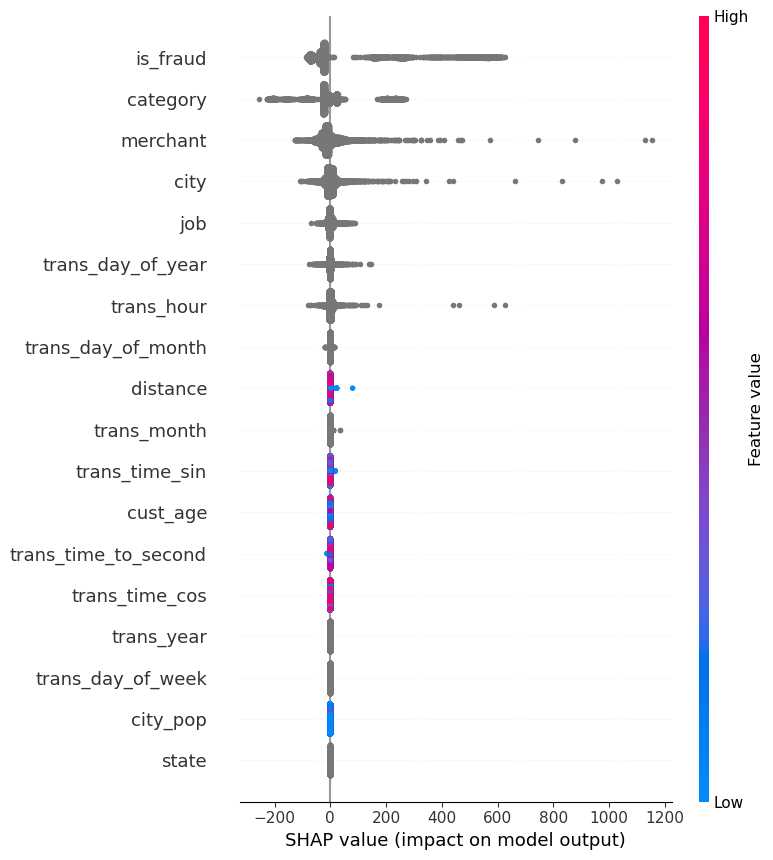

In [66]:
optimal_rounds = score.shape[0]

# Step 2: Train the final model with the optimal number of rounds
final_model = xgb.train(params, DMatrix, num_boost_round=optimal_rounds)

# Step 3: Calculate SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(xgb.DMatrix(X, enable_categorical=True))

# Display SHAP summary plot
shap.summary_plot(shap_values, X)

# Experiment 2

In [69]:
data = pd.read_excel('../../data/fraud.xlsx')
# Data Cleaning Steps
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], errors='coerce')
data['dob'] = pd.to_datetime(data['dob'], errors='coerce')
data['is_fraud'] = data['is_fraud'].astype(str).str.replace('1"2020-12-24 16:56:24"', '1')
data['is_fraud'] = data['is_fraud'].str.replace('0"2019-01-01 00:00:44"', '0')
data['is_fraud'] = data['is_fraud'].astype(int)
data['merchant'] = data['merchant'].str.replace(r'^"|"$', '', regex=True)
data['job'] = data['job'].str.replace(r'^"|"$', '', regex=True)
data = data.drop_duplicates(subset='trans_num', keep='first')
data = data.sort_values(by='trans_date_trans_time')
data['merchant'] = data['merchant'].astype('category')
data['category'] = data['category'].astype('category')
data['city'] = data['city'].astype('category')
data['state'] = data['state'].astype('category')
data['job'] = data['job'].astype('category')
data['is_fraud'] = data['is_fraud'].astype('category')
data['trans_num'] = data['trans_num'].astype('category')

X = data.drop(columns=['amt', 'trans_num'])
y = data['amt']

X['trans_year'] = X['trans_date_trans_time'].dt.year.astype('category')
X['trans_month'] = X['trans_date_trans_time'].dt.month.astype('category')
X['trans_day_of_month'] = X['trans_date_trans_time'].dt.day.astype('category')
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.day_of_week.astype('category')
X['trans_day_of_year'] = X['trans_date_trans_time'].dt.day_of_year.astype('category')
X['trans_hour'] = X['trans_date_trans_time'].dt.hour.astype('category')
X['trans_time_to_second'] = (
    X['trans_date_trans_time'].dt.hour*3600 + 
    X['trans_date_trans_time'].dt.minute*60 + 
    X['trans_date_trans_time'].dt.second
)
X['cust_age'] = (X['trans_date_trans_time'] - data['dob']).dt.days // 365
X['trans_time_sin'] = np.sin(2 * np.pi * X['trans_time_to_second'] / 86400)
X['trans_time_cos'] = np.cos(2 * np.pi * X['trans_time_to_second'] / 86400)
X['distance'] = X.apply(lambda row: geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).meters, axis=1)

X = X[['trans_day_of_year', 'category', 'merchant', 'city', 'job', 'trans_hour', 'is_fraud']]

DMatrix = xgb.DMatrix(X, label=y, enable_categorical=True)

In [70]:
# Parameters
params = {
    'objective': 'reg:squarederror',
    'seed': RANDOM_STATE,
    'eval_metric': 'rmse',  # This is for RMSE
}

# Train with custom MAPE metric added
results = xgb.cv(
    params,
    DMatrix,
    nfold=5,
    num_boost_round=1000,
    early_stopping_rounds=10,
    verbose_eval=100,
    maximize=False
)

[0]	train-rmse:171.13268+1.82864	test-rmse:180.19335+9.40715
[16]	train-rmse:34.87888+2.25914	test-rmse:126.10036+13.20331


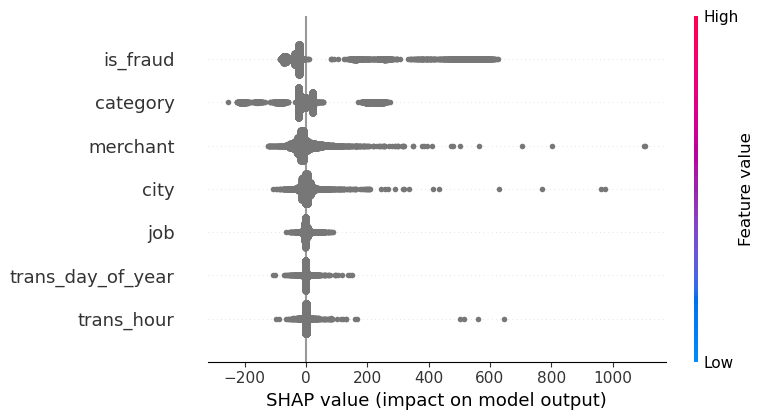

In [71]:
optimal_rounds = score.shape[0]

# Step 2: Train the final model with the optimal number of rounds
final_model = xgb.train(params, DMatrix, num_boost_round=optimal_rounds)

# Step 3: Calculate SHAP values
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(xgb.DMatrix(X, enable_categorical=True))

# Display SHAP summary plot
shap.summary_plot(shap_values, X)